In [2]:
# General libraries.
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import mixture

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.metrics import accuracy_score

# import text edit and embedding libraries
from gensim.models import KeyedVectors
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')

# Make sure data is in "Data" folder which is in the same location as this notebook
#os.getcwd()
os.chdir('Data')
#os.getcwd()
#os.chdir('C:\Users\zolotab\Desktop\w207-Machine-Learning-Final-Project-master\w207-Machine-Learning-Final-Project-master\Data')


# load data from json files to df
with open('train.json') as fin:
    trainjson = json.load(fin)

with open('test.json') as fin:
    testjson = json.load(fin)
    
df_train = pd.io.json.json_normalize(trainjson)
df_test = pd.io.json.json_normalize(testjson)

# randomize and split data set into train test and dev using 60/20/20 split
np.random.seed(33)
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train_data, df_train_labels = df_train.ix[shuffle, :], df_train.ix[shuffle, 'requester_received_pizza']

# Set some variables to test, dev and training data
cutoff1 = int(df_train_labels.shape[0]*0.6)
cutoff2 = int(df_train_labels.shape[0]*0.8)
train_data, train_labels = df_train_data[:cutoff1], df_train_labels[:cutoff1]
dev_data, dev_labels = df_train_data[cutoff1:cutoff2], df_train_labels[cutoff1:cutoff2]
test_mini_data, test_mini_labels = df_train_data[cutoff2:], df_train_labels[cutoff2:]

# Create field that concatenates the request text and title in case the title contains more predictive power
train_data['request_title_and_text'] = train_data['request_title'] + ' ' + train_data['request_text_edit_aware']
dev_data['request_title_and_text'] = dev_data['request_title'] + ' ' + dev_data['request_text_edit_aware']
test_mini_data['request_title_and_text'] = test_mini_data['request_title'] + ' ' + test_mini_data['request_text_edit_aware']

train_txt_df = train_data['request_title_and_text']
dev_txt_df = dev_data['request_title_and_text']
mini_txt_df = test_mini_data['request_title_and_text']

print ('train data shape: ', train_data.shape)
print ('dev data shape:', dev_data.shape)
print ('test data shape:', test_mini_data.shape)

train data shape:  (2424, 33)
dev data shape: (808, 33)
test data shape: (808, 33)


#### Text Embedding Model

In [8]:
# training the wordvec models
#filename = 'Data/GoogleNews-vectors-negative300.bin'
#g_model = KeyedVectors.load_word2vec_format(filename, binary=True)

filename = '/Users/jmcdonald/UCB/Glove/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

def word_to_vec(text_data):
    new_array = []
    for item in text_data:
        temp = []
        item = preprocess_text(item)
        for word in item:
            if word in model.vocab:
                val = model[word]
                temp.append(val)
        new_array.append(np.average(temp, axis=0))
    return new_array

#### Text Preprocessing

In [9]:
# Removing stemming and lemmatization
# Removing stopwords and punctuations
stopwords_en = set(stopwords.words('english'))

# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)


wnl = WordNetLemmatizer()

# tagging part of speech so that lemmatization can be done
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

# updated preprocessor

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    # Convert all text to lowercase
    text = text.lower()
    
    # Replace sequences of numbers with a single token
    text = re.sub(r'\d+','numseq',text)
    
    # Remove non letter characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

#### Logisitic modeling

In [10]:
# Logisitic modeling - running on embeded text data
wtv_train_df = word_to_vec(train_txt_df)
wtv_dev_df = word_to_vec(dev_txt_df)
wtv_mini_df = word_to_vec(mini_txt_df)

# Optional code to run PCA
#pca = PCA(n_components=50)
#wtv_train_df = pca.fit_transform(wtv_train_df)
#wtv_dev_df = pca.transform(wtv_dev_df)
#wtv_mini_df = pca.transform(wtv_mini_df)

log_clf = LogisticRegression()
C = {"C": [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 5, 10]}
log_gs = GridSearchCV(log_clf,C)
log_gs.fit(wtv_dev_df, dev_labels)

log_clf_best = LogisticRegression(C=log_gs.best_params_['C'])
log_clf_best.fit(wtv_train_df, train_labels)
log_clf_best_predicted = log_clf_best.predict(wtv_mini_df)
fpr, tpr, _ = metrics.roc_curve(test_mini_labels, log_clf_best_predicted)

print('----- Logistic Regression -----')
print (log_gs.best_params_)
accuracy = accuracy_score(log_clf_best_predicted, test_mini_labels) * 100
print ('Logistic accuracy: {:2.3f}%'.format(accuracy))
print ('Logistic accuracy (AUC): {:2.3f}%'.format(metrics.auc(fpr,tpr) * 100))
print('Number of predictions:', len(log_clf_best_predicted))
print('Number predicted will get pizza:',sum(log_clf_best_predicted))
print('-----------------------------------')

----- Logistic Regression -----
{'C': 0.001}
Logistic accuracy: 76.733%
Logistic accuracy (AUC): 50.000%
Number of predictions: 808
Number predicted will get pizza: 0
-----------------------------------


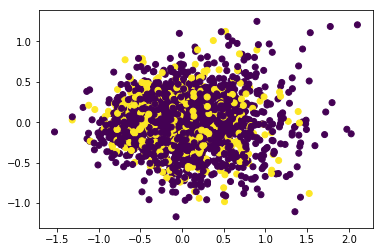

In [11]:
pca = PCA(n_components=2)
wtv_train_df_pca = pca.fit_transform(wtv_train_df)
plt.scatter(wtv_train_df_pca[:,0],wtv_train_df_pca[:,1],c=train_labels)
plt.show()